### Clean Data

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the dataset
df = pd.read_csv('profiles.csv')

# check it out
#print(df.head())
#print(df.columns)
#df.info()

# remove all the essay columns, won't be numerical or relevant
cols_to_keep = [col for col in df.columns if not col.startswith('essay')]
df = df[cols_to_keep]
#print(df.columns)

# let's convert as many columns to numbers as possible

# check out the unique answers for each columns
# for col in df.columns:
#     print(col)
#     print(df[col].unique())
#     print()

# subset to numerical columns and columns that appear reasonable to numerically encode
num_cols = ['age', 'drinks', 'drugs', 'height', 'orientation', 'sex', 'smokes', 'status']
df = df[num_cols]

# for col in df.columns:
#     print(col)
#     print(df[col].unique())
#     print()

df = df.dropna()

# drinking
df['drinks'] = df['drinks'].map({'not at all' : 0, 'rarely' : 1, 'socially' : 2, 'often' : 3, 'very often' : 4, 'desperately' : 5})

# drugs
df['drugs'] = df['drugs'].map({'never' : 0, 'sometimes' : 1, 'often' : 2})

# height (some strange answers here like less than 10. I'll "trust" > 90 people, but removing the less than 10 outliers.
df = df[df.height > 10]
df['height'] = df['height'].astype(int)

# encode orientation as either 'straight' or 'not straight'
df['orientation'] = df['orientation'].apply(lambda x: 0 if x == 'straight' else 1)

# sex 
df['sex'] = df['sex'].map({'m' : 0, 'f' : 1})

#smokes (0 for never, 1 for anything in between, 2 for yes
df['smokes'] = df['smokes'].apply(lambda x: 0 if x == 'no' else 2 if x == 'yes' else 1)

#status (map 0 for "single and "available" and 1 for everything else
df['status'] = df['status'].apply(lambda x: 0 if x == 'single' or x == 'available' else 1)

df.to_csv('okCupidMLmatrix.csv', index=False)

### Pandas correlation

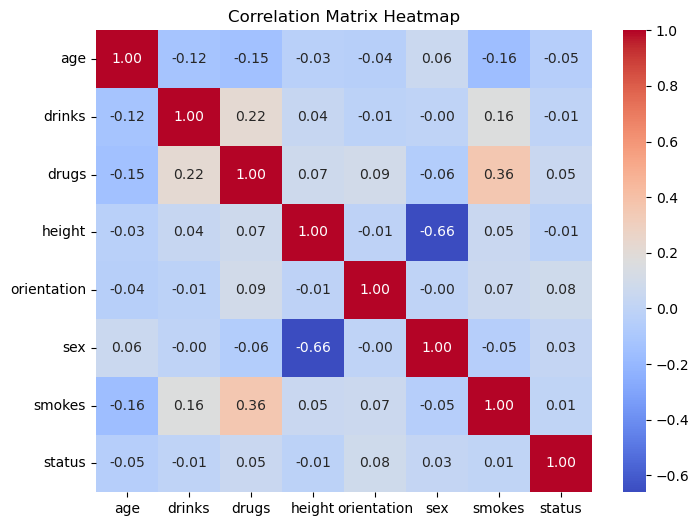

In [45]:
corr = df.corr()

# heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Dating app Correlation Matrix")
plt.show()

### Supervised ML: Predict age using random forest regressor

Results: Horrible model with nearly no predictive power. See metrics below.

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = df.drop(columns='age')
y = df['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=49)

model =  RandomForestRegressor(random_state = 49)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = model.score(X_test, y_test)
print("R^2 score: " + str(score))
test_mse = mean_squared_error(y_test, y_pred)
print("Test Set MSE:", test_mse)

R^2 score: 0.020879721631981596
Test Set MSE: 95.54380285536578


### Unsupervised ML: k-means clustering

Results: Unsurprisingly, with the top two features from the PCA being height and sex, this model grouped people into male and female groups.

In [55]:
# unsupervised: k-means clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def kMeansLabelsPCA(features_df, num_clusters):
    a = features_df.dropna()
    a = a.astype(int)
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    model = KMeans(init='k-means++', n_clusters=num_clusters, random_state=49)
    labels = model.fit_predict(a_scaled)
    #print(model.cluster_centers_)
    labeled_points = pd.DataFrame(labels, index=a.index, columns=['label'])
    
    # PCA to determine which features contribute most to variance
    pca = PCA()
    pca.fit(a_scaled)
    
    feature_importance = pd.DataFrame(pca.components_, columns=features_df.columns, index=[f'PC{i+1}' for i in range(len(features_df.columns))])
    
    # focus on first principal component
    pc1_contributions = feature_importance.loc['PC1']
    important_features_pc1 = pc1_contributions.abs().sort_values(ascending=False)
    
    return labeled_points, important_features_pc1

labels, feature_importance = kMeansLabelsPCA(df, 2)
results = df.join(labels, how='inner')

# Print feature importance for PC1
print("PC1 Feature Importance:")
print(feature_importance)

42491
PC1 Feature Importance:
height         0.535550
sex            0.529746
drugs          0.396204
smokes         0.366440
age            0.260793
drinks         0.255800
orientation    0.084591
status         0.026393
Name: PC1, dtype: float64


### Classification ML - K nearest neightbors

Predict body type classification using transformed data

See scoring metrics below. Correctly classified many "athletic" and "average" body types, big reason was probably that the model learned to mostly classify as these frequent types.


Accuracy: 0.23
Precision: 0.22
Recall: 0.23
f1 score: 0.22


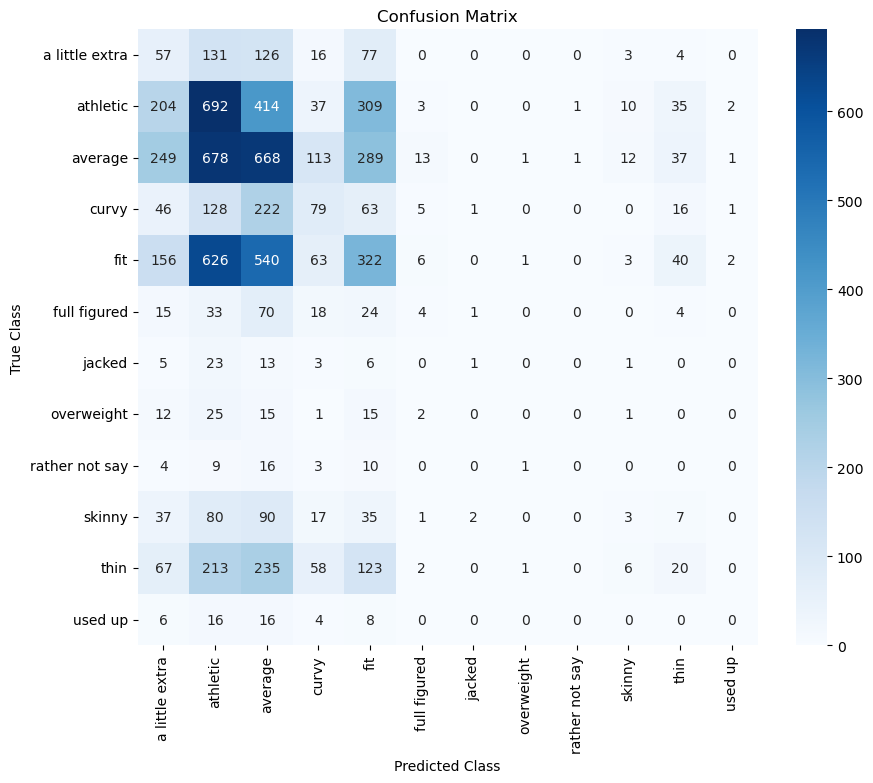

In [81]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

original = pd.read_csv('profiles.csv')

df['body_type'] = original['body_type']

df = df.dropna()

X = df.drop(columns='body_type')
y = df['body_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=49)

model =  RandomForestRegressor(random_state = 49)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

k = 3  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"f1 score: {f1:.2f}")


# Plot the confusion matrix
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))

# Add labels and title
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()